# Exploratory data analysis notebook focusing on snippy recall (not sure if we need to look at precision)

In [288]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

# Data input

For each triple (gene, truth, reference), we know the nb of truth variants in that gene (max_recall), the nb of truth variants snippy was able to call (observed_recall) and thus the recall performance (recall_ratio = observed_recall / max_recall). We also know the edit distance of the gene between the ref and the truth (distance).

In [289]:
df = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/all_gene_truth_ref_recall_proportion_distance.csv")
df

,gene,truth,ref,distance,max_recall,observed_recall,recall_ratio
0,Cluster_10085,H131800734,NZ_CP016182.1,0.000000,6,0.0,0.000000
1,Cluster_1009,H131800734,NZ_CP016182.1,0.000000,6,0.0,0.000000
2,Cluster_10093,H131800734,NZ_CP016182.1,0.000000,2,0.0,0.000000
3,Cluster_10094,H131800734,NZ_CP016182.1,0.032967,5,5.0,1.000000
4,Cluster_1011,H131800734,NZ_CP016182.1,0.000000,12,1.0,0.083333
...,...,...,...,...,...,...,...
9363061,GC00010496,063_STEC,CP010140.1,0.030864,12,8.0,0.666667
9363062,GC00010497,063_STEC,CP010140.1,0.026144,9,6.0,0.666667
9363063,GC00010787,063_STEC,CP010140.1,0.020080,5,5.0,1.000000
9363064,GC00010870,063_STEC,CP010140.1,0.015152,3,3.0,1.000000


# Main helper functions

In [290]:
def get_bounds(step, max_bin):
    bounds = [0.0]
    current_step = step
    while current_step <= max_bin:
        bounds.append(current_step)
        current_step += step
    return bounds

def get_edit_distance_label(row, bounds):
    distance = row["distance"]
    for upper_bound in bounds[1:]:
        if distance < upper_bound:
            return upper_bound
    return bounds[-1]
    

def get_df_with_edit_distance_labels (df, having_at_least_n_variants, step, max_bin):
    df = df.query("max_recall >= @having_at_least_n_variants")
    bounds = get_bounds(step, max_bin)
        
    edit_distance_labels = df.apply(get_edit_distance_label, axis=1, bounds=bounds)
    df["edit_distance_labels"] = edit_distance_labels
    return df

# Cached dfs for easier processing

In [291]:
df_with_step_0001 = get_df_with_edit_distance_labels(df, having_at_least_n_variants=1, step = 0.001, max_bin = 0.2)
df_with_step_001 = get_df_with_edit_distance_labels(df, having_at_least_n_variants=1, step = 0.01, max_bin = 0.2)


# Results



## Plotting the mean recall_ration in each bin as a lineplot

For all triples (gene, truth, reference), we plot the recall_ratio divided into bins by the edit distance.

In [292]:
def plot_lineplot_mean_recall_in_genes_in_several_bins(df, step):
    ax = sns.lineplot(x="edit_distance_labels", y="recall_ratio", data=df)
    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel='Mean recall score per bin')
    ax.plot()

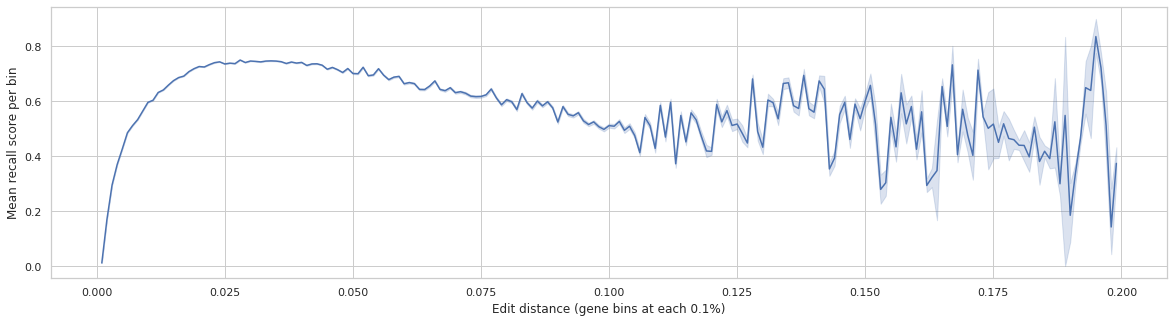

In [293]:
plot_lineplot_mean_recall_in_genes_in_several_bins(df_with_step_0001, step=0.001)

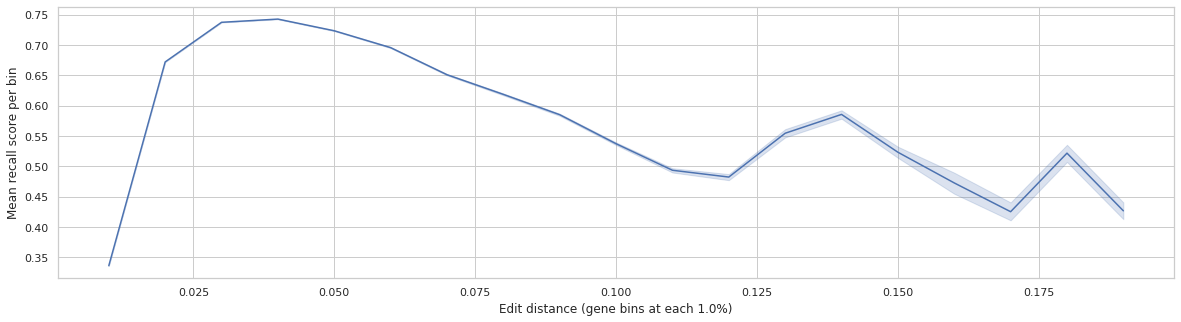

In [294]:
plot_lineplot_mean_recall_in_genes_in_several_bins(df_with_step_001, step=0.01)

## Explanation:

### Edit distance too low (~ < 0.5%):

Very few variants that mapping can find (reference and truth genes are way too similar, not many variants found by mapping (think about the extreme example where the gene as 0 edit distance)). Found variants can't cover all truth variants, thus recall is very low;

### Edit distance moderate (2% - 5%):

Sweet spot: 1) edit distance is not too low, so we can find a bunch of variants to cover the truth variants; 2) edit distance is not too high to avoid mapping;

### Edit distance too high (>20%, we don't manage to map genes in this case) TODO: TO SHOW:

We don't manage to map genes, and I guess snippy also does not manage to map a lot of reads, thus recall too low (TODO: to show, but in one pair of (ref, truth) the mean recall was ~0.25% in variants that did not lie on any gene).

* How to show this information?
  * Show a single data point with the recall score on variants lying on regions where we did not identify a gene (like giving all these variants a gene named "Unmapped" with edit distance = 2 (to denote it is unmapped))?
  * Or this should be shown in another plot (maybe like this one, but variants classified into two classes: lying on mapped or unmapped genes)?
  * TODO: even with this, maybe there are still good regions, where edit distance is moderate. Edit distance between genes is a global measure, variant calling is local;

### Edit distance between 10 and 20%

I have no idea what is happening. The results get really weird...

One thing to note is that each data point is the average of gene recall score, so the points in the lineplot are an average of an average (average of genes in a bin, and a gene recall is an average of the recall of the variants in that gene). And most genes have very few variants, so this skew the results towards the extremes (think of a situation with 4 genes, 1 with 50 variants, but 40 are found (recall score 0.8) and 3 others with only 1 variant, but none found. If all these variants are in a bin, the average in this bin is 0.2). If we however do not group by genes, then the recall will be ~0.8%. Could it be this? Does it make sense still to keep grouping variants by gene?

# Checking if it is because after 10% edit distance, we have very few genes in the bins

Maybe it is just that we have very few genes in bins after 10%, so results could get weird (no statistical power)?

In [295]:
def plot_lineplot_count_genes_in_several_bins(df, step):
    count_df = df.groupby(by="edit_distance_labels", as_index=False).count()
    ax = sns.lineplot(x="edit_distance_labels", y="gene", data=count_df)
    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel='Number of genes per bin')
    ax.plot()


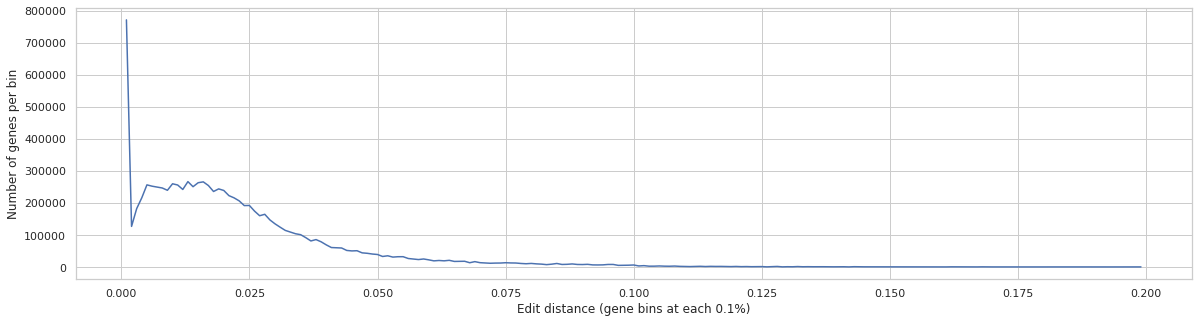

In [297]:
plot_lineplot_count_genes_in_several_bins(df_with_step_0001, step=0.001)

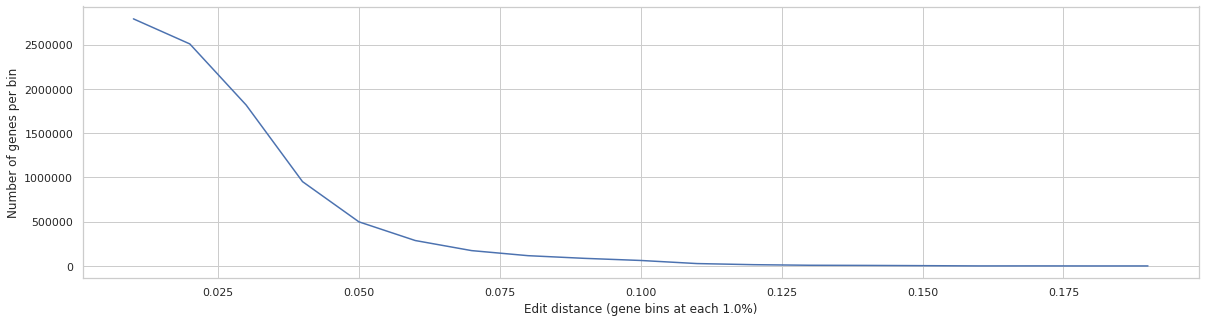

In [296]:
plot_lineplot_count_genes_in_several_bins(df_with_step_001, step=0.01)

# Combining mean recall and counts plot into one to show that we should not worry > 10%

In [302]:
def plot_lineplot_mean_recall_and_count_in_genes_in_several_bins(df, step):
    ax = sns.lineplot(x="edit_distance_labels", y="recall_ratio", data=df, color='b')
    count_df = df.groupby(by="edit_distance_labels", as_index=False).count()
    ax2 = ax.twinx()
    sns.lineplot(x="edit_distance_labels", y="gene", data=count_df, ax=ax2, color='r')
    
    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel='Mean recall score per bin')
    ax2.set(ylabel='Number of genes per bin')

    ax.figure.legend()
    ax.plot()

No handles with labels found to put in legend.


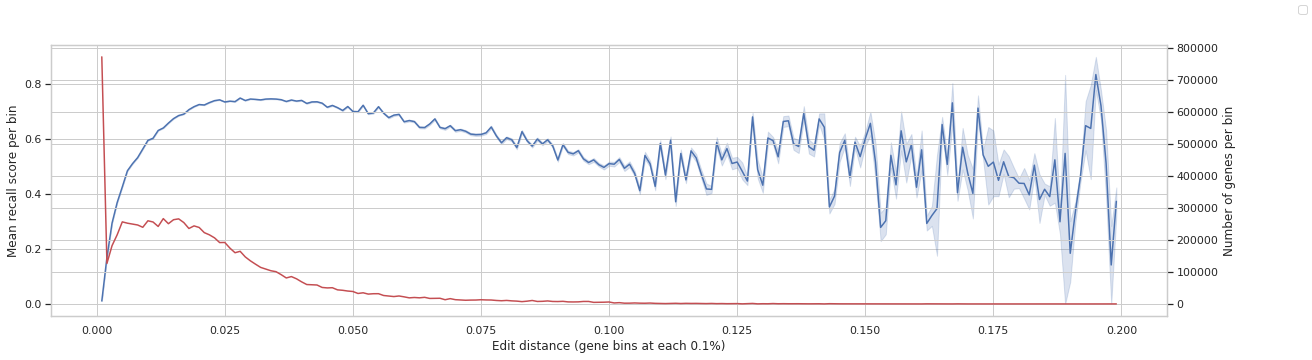

In [303]:
plot_lineplot_mean_recall_and_count_in_genes_in_several_bins(df_with_step_0001, step=0.001)

No handles with labels found to put in legend.


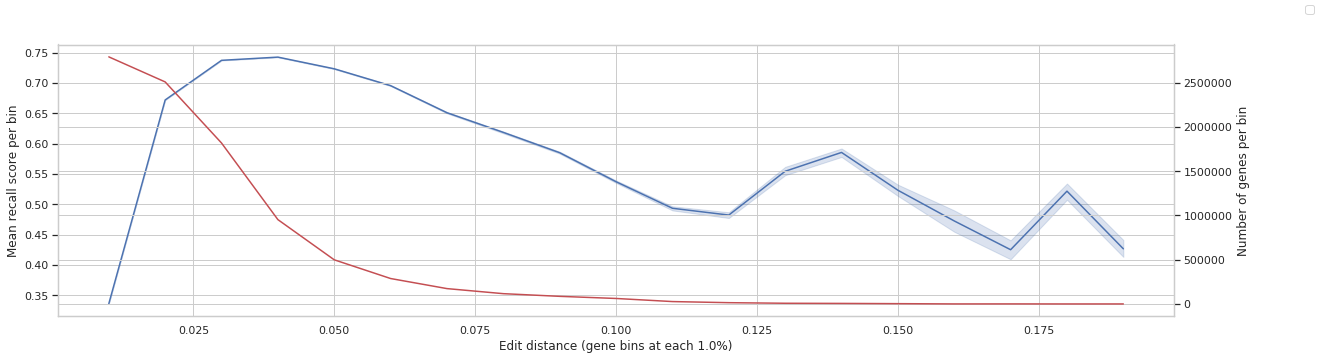

In [304]:
plot_lineplot_mean_recall_and_count_in_genes_in_several_bins(df_with_step_001, step=0.01)

# Plotting the violing plot per bin

In [312]:
def plot_violinplot_recall_in_genes_in_several_bins(df, step, scale):
    plt.rcParams['figure.figsize'] = [50, 5]
    ax = sns.violinplot(x="edit_distance_labels", y="recall_ratio", data=df, scale=scale)
    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel='Recall ratio per bin')
    ax.plot()
    plt.rcParams['figure.figsize'] = [20, 5]

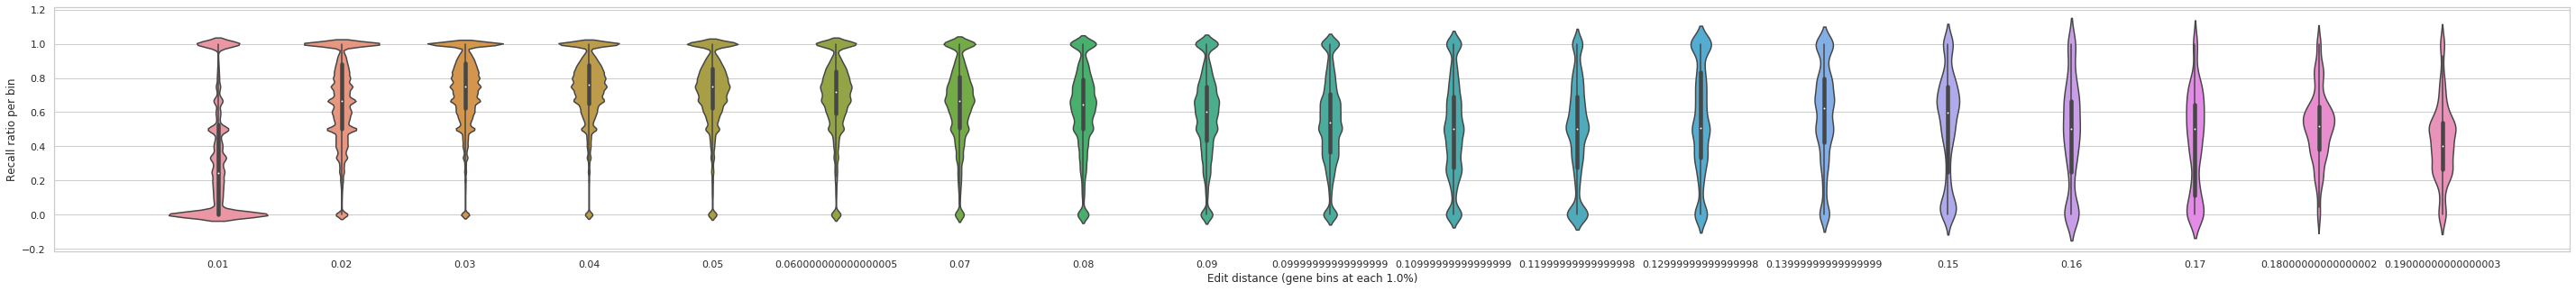

In [310]:
plot_violinplot_recall_in_genes_in_several_bins(df_with_step_001, step=0.01, scale="area")

Notes:
1. genes bins at each 1% edit distance

2. Note the large distribution of recall_ratio=0 genes in the first bin (edit distance 0.0-0.1): these are the very low edit distance genes having 0 recall. No other bin has such large distribution.

## Scaling by count (the width of the violins will be scaled by the number of observations in that bin):

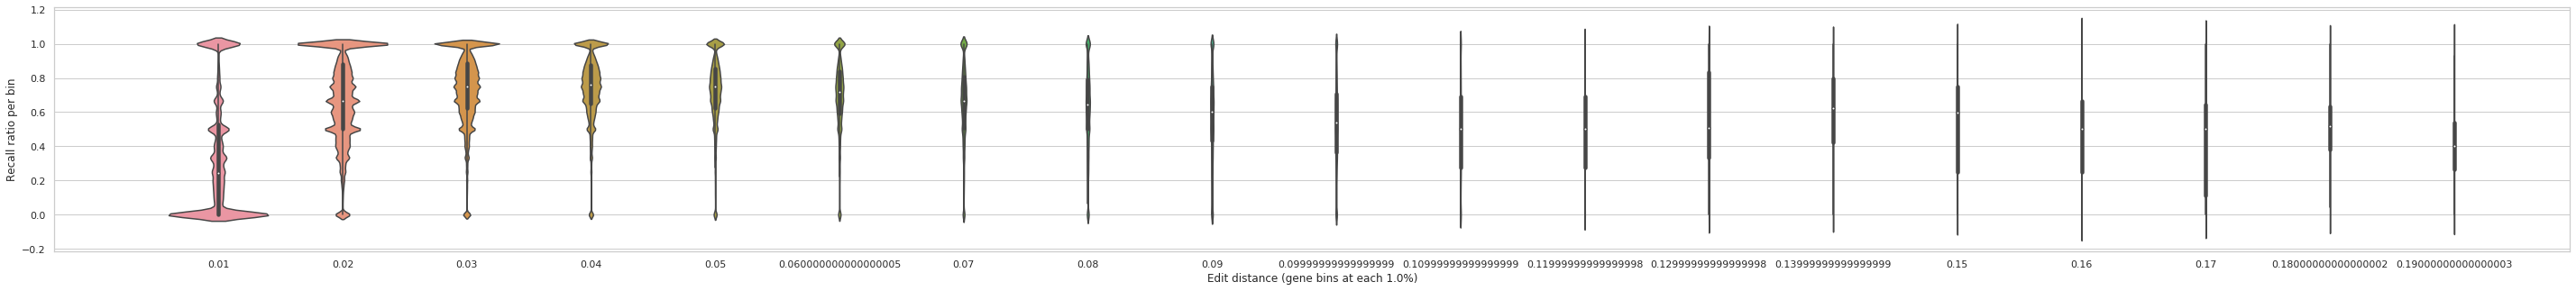

In [311]:
plot_violinplot_recall_in_genes_in_several_bins(df_with_step_001, step=0.01, scale="count")